# Time-Series 101: Reading the Pulse of the World

Welcome to **Time-Series 101**, an educational notebook designed to introduce you to the core concepts of time-series analysis, from lag-based modeling to frequency-domain intuition — all using real-world COVID-19 case data from Barcelona.

> 📍 This notebook is beginner-friendly but mathematically curious. Perfect for anyone who wants to go beyond tutorials and build strong intuition.

---

## What's Inside?

-  **Time-Domain Intuition**: Learn how today's values depend on previous days using lag structures and autoregressive models.
-  **GRU Forecasting Example**: Train a simple GRU (Gated Recurrent Unit) model to predict daily COVID-19 cases.
-  **Frequency-Domain Perspective**: Explore how seasonality and cycles are captured using spectral tools (coming soon).
-  **Conceptual Insights**: Theory meets hands-on coding, with explanations alongside code blocks.
- ️ **Modular Helpers**: Preprocessing, training, and evaluation are split into reusable functions for clarity and reuse.

---


In [65]:
from helpers import preprocess_series, get_dataloaders, train_model, evaluate_model
from models.blog_one_models import GRUModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [66]:
# Load and prepare data
df = pd.read_csv('../../data/Time-Series-101-Data/spain-covid-data.csv')
df['Fecha'] = pd.to_datetime(df['Fecha'])
cases = df[df['provincia'] == 'Barcelona'].sort_values('Fecha')['Casos'].fillna(0).values.astype(np.float32)

X_train, y_train, X_test, y_test, _, scaler_y = preprocess_series(cases)
train_loader = get_dataloaders(X_train, y_train)

In [67]:
# Train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GRUModel()
trained_model = train_model(model, train_loader, n_epochs=40, device=device)

Epoch 10/40 - Loss: 0.0192
Epoch 20/40 - Loss: 0.0125
Epoch 30/40 - Loss: 0.0085
Epoch 40/40 - Loss: 0.0085


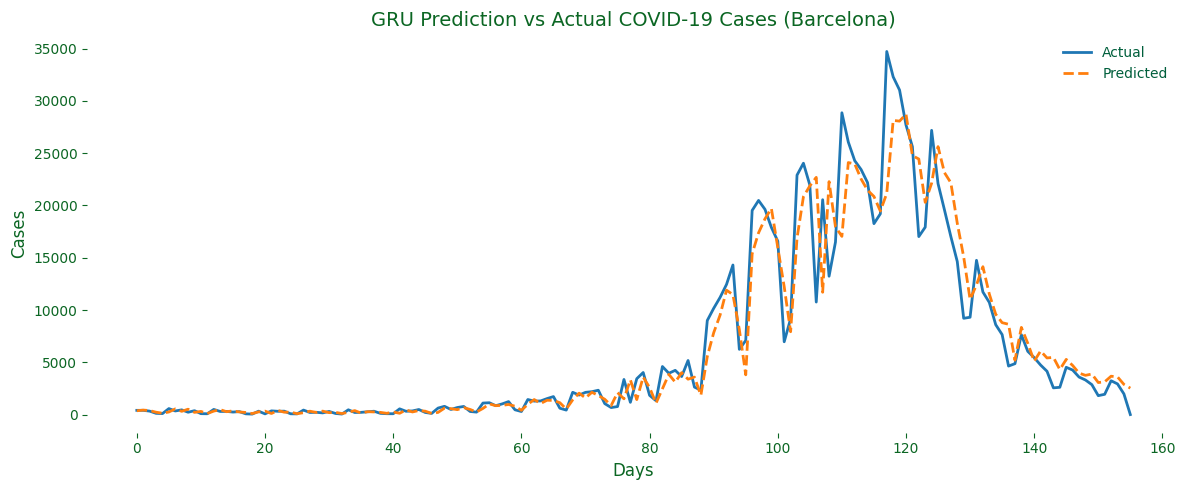

In [69]:
# Evaluate
y_true, y_pred = evaluate_model(trained_model, X_test, y_test, scaler_y, device)

plt.figure(figsize=(12, 5))

# Colors
text_color = "#0b6623"          # Dark green (good contrast on both themes)

# Plot lines
plt.plot(y_true, label="Actual", linewidth=2)
plt.plot(y_pred, label="Predicted", linestyle="--", linewidth=2)

# Labels and title with dark green
plt.title("GRU Prediction vs Actual COVID-19 Cases (Barcelona)", fontsize=14, color=text_color)
plt.xlabel("Days", fontsize=12, color=text_color)
plt.ylabel("Cases", fontsize=12, color=text_color)

# Set tick label colors
plt.tick_params(axis='x', colors=text_color)
plt.tick_params(axis='y', colors=text_color)

# Optional: Remove borders
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Legend
plt.legend(facecolor='none', edgecolor='none', labelcolor='#005f3c')

# Save with transparent background
plt.tight_layout()
plt.savefig("./assets/gru_prediction_plot.png", dpi=50, transparent=True)
plt.show()


## 🔁 Frequency-Domain Analysis of COVID-19 Cases in Barcelona

In this section, we zoom out from the raw case numbers and ask a new question:

> **“Are there any repeating patterns in the data?”**

To answer that, we use the **Fast Fourier Transform (FFT)** to move from the **time domain** into the **frequency domain**.

---

### What We Did:

1. **Loaded** the Barcelona COVID-19 daily case counts.
2. **Applied a Hamming window** to smooth the edges and reduce spectral leakage.
3. **Performed FFT** to compute the signal's frequency spectrum.
4. **Converted frequencies to periods (in days)** to interpret results in human terms.
5. **Filtered out very long cycles** (> 60 days) to focus on more meaningful ones.
6. **Highlighted the weekly cycle** (7 days), which often reflects real-world testing/reporting rhythms.

---

### What You See in the Plot:

- Peaks in the plot indicate **dominant cycles** in the data.
- The **7-day peak** reflects the **weekly cycle** common in pandemic data due to human behavior and reporting.
- We also see a possible **3.5-day harmonic**, which may reflect sub-weekly dynamics or noise.

This is a powerful tool for detecting seasonality, habits, and hidden structure in time-series data.


In [70]:
# Reload the data
df_frequency = pd.read_csv('../../data/Time-Series-101-Data/spain-covid-data.csv')
df_frequency['Fecha'] = pd.to_datetime(df_frequency['Fecha'])
cases = df_frequency[df_frequency['provincia'] == 'Barcelona'].sort_values('Fecha')['Casos'].fillna(0).values.astype(np.float32)

In [71]:
# --- Step 1: Apply a window function ---
window = np.hamming(len(cases))
windowed_signal = cases * window

In [72]:
# --- Step 2: FFT ---
fft_vals = np.fft.fft(windowed_signal)
power = np.abs(fft_vals) ** 2
freqs = np.fft.fftfreq(len(windowed_signal), d=1)

# Keep only positive frequencies (exclude DC)
half_n = len(freqs) // 2
freqs = freqs[1:half_n]
power = power[1:half_n]
periods = 1 / freqs

# --- Step 3: Limit to meaningful periods (under 60 days) ---
mask = periods < 60
periods_masked = periods[mask]
power_masked = power[mask]

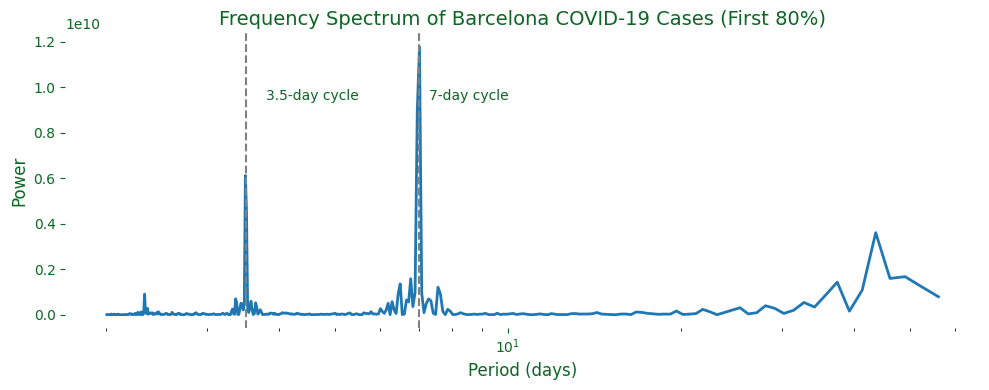

In [73]:
# --- Plot ---
text_color = "#0b6623"
plt.figure(figsize=(10, 4))
plt.plot(periods_masked, power_masked, linewidth=2)

plt.xscale('log')
plt.xlabel("Period (days)", fontsize=12, color=text_color)
plt.ylabel("Power", fontsize=12, color=text_color)
plt.title("Frequency Spectrum of Barcelona COVID-19 Cases (First 80%)", fontsize=14, color=text_color)

# Highlight weekly periodicity

plt.axvline(x=3.5, color='gray', linestyle='--')
plt.text(3.8, max(power_masked) * 0.8, "3.5-day cycle", color=text_color)

plt.axvline(x=7, color='gray', linestyle='--')
plt.text(7.3, max(power_masked) * 0.8, "7-day cycle", color=text_color)

# Clean styling
plt.tick_params(axis='x', colors=text_color)
plt.tick_params(axis='y', colors=text_color)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.savefig("./assets/fft_barcelona.png", dpi=50, transparent=True)
plt.show()

## 🔊 White Noise Variants — Visualization & Summary

In this section, we simulate and visualize 3 key types of white noise:

- **White Noise (WN)**  
  A general sequence with zero mean, constant variance, and no autocorrelation.  
  We used:  
  $$
  w_t = (-1)^t \cdot z_t, \quad z_t \sim \mathcal{N}(0, 1)
  $$  
  This breaks independence, since there's a deterministic pattern — it's **not IID**.

- **IID Noise**  
  Values are independently and identically drawn from a non-Gaussian distribution:  
  $$
  w_t \overset{\text{iid}}{\sim} \mathcal{U}(-1, 1)
  $$  
  This satisfies both uncorrelatedness and independence but not Gaussianity.

- **Gaussian White Noise**  
  Combines all three properties: uncorrelated, IID, and Gaussian:  
  $$
  w_t \sim \mathcal{N}(0, \sigma^2)
  $$


In [59]:
np.random.seed(42)
n = 200
sigma = 1

# 1. White Noise (WN): (Most General thus we can sample from any distribution) zero-mean, constant variance, uncorrelated
# w_t = (-1)^t * z_t
white_noise = ((-1) ** np.arange(n)) * np.random.normal(0, 1, size=n)

# 2. IID noise: same as WN, but can use non-Gaussian distribution
iid_noise = np.random.uniform(-1, 1, size=n)

# 3. Gaussian White Noise: WN + Gaussian + IID
gaussian_white_noise = np.random.normal(0, 1, size=n)

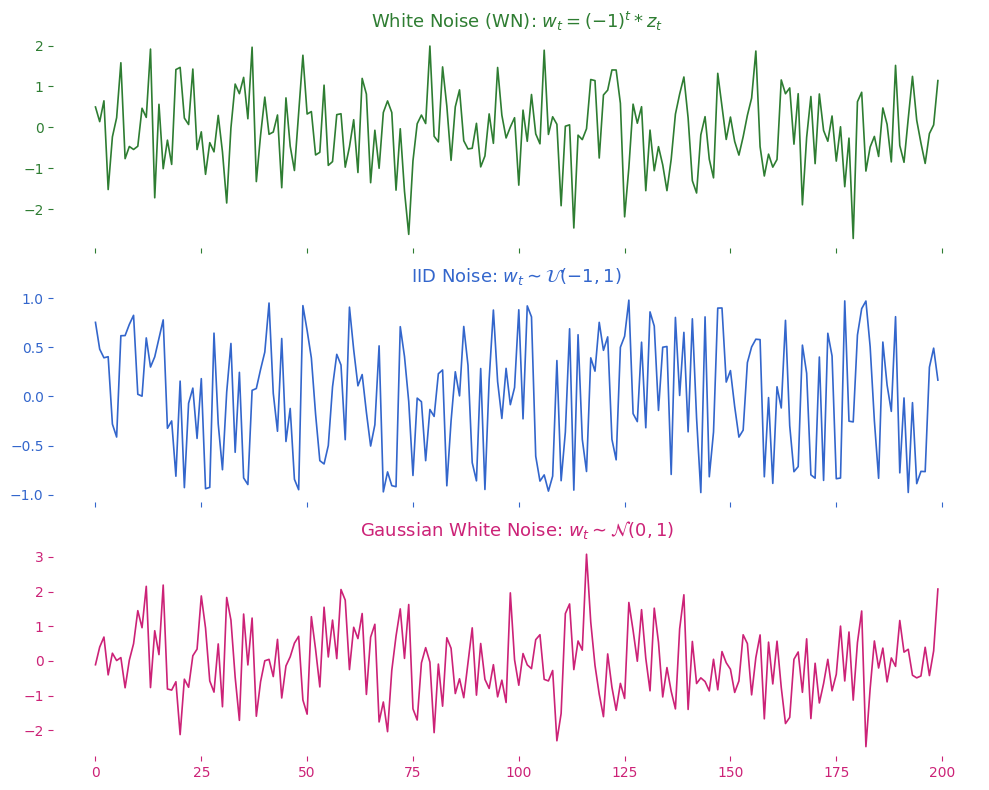

In [64]:
# --- Plot ---
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# Colors & labels
colors = ["#2e7d32", "#3366cc", "#cc2277"]
titles = [
    "White Noise (WN): $w_t = (-1)^t * z_t$",
    "IID Noise: $w_t \\sim \\mathcal{U}(-1, 1)$",
    "Gaussian White Noise: $w_t \\sim \\mathcal{N}(0, 1)$"
]
noises = [white_noise, iid_noise, gaussian_white_noise]

for i in range(3):
    axs[i].plot(noises[i], color=colors[i], linewidth=1.2)
    axs[i].set_title(titles[i], fontsize=13, color=colors[i])
    axs[i].tick_params(colors=colors[i])
    for spine in axs[i].spines.values():
        spine.set_visible(False)

plt.tight_layout()
plt.savefig("./assets/white_noise_variants.png", dpi=50, transparent=True)
plt.show()

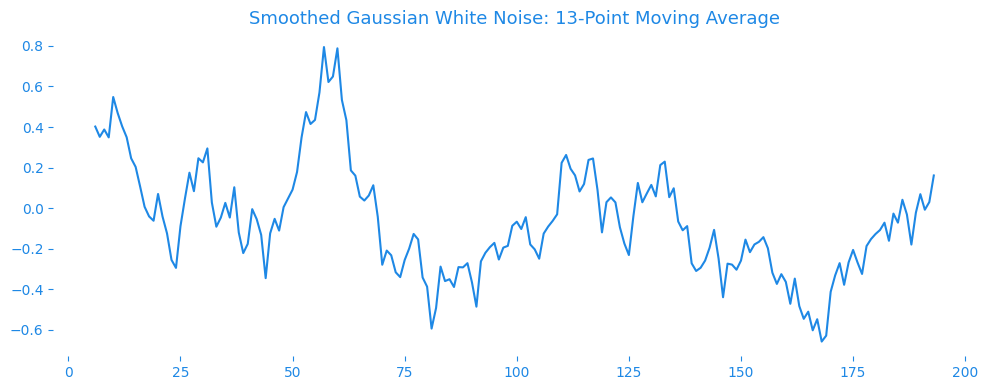

In [84]:
# --- 13-Point Moving Average ---
def moving_average(series, moving_window=13):
    return np.convolve(series, np.ones(moving_window) / moving_window, mode='valid')

smoothed_noise = moving_average(gaussian_white_noise, moving_window=13)

# Adjusted time index since we're using 'valid' mode
smoothed_time = np.arange(6, len(gaussian_white_noise) - 6)

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 4))

# Plot
ax.plot(smoothed_time, smoothed_noise, color="#1e88e5", linewidth=1.5)

# Styling
ax.set_title("Smoothed Gaussian White Noise: 13-Point Moving Average", fontsize=13, color="#1e88e5")
ax.tick_params(colors="#1e88e5")
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.savefig("./assets/smoothed_gaussian_white_noise.png", dpi=300, transparent=True)
plt.show()


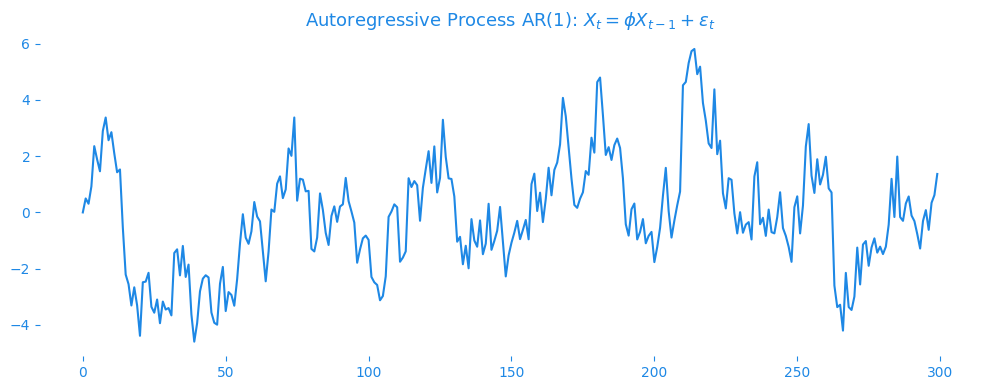

In [110]:
# --- AR(1) Generation ---
phi = 0.9
n = 300
ar = np.zeros(n)

np.random.seed(42)
for t in range(1, n):
    ar[t] = phi * ar[t - 1] + np.random.normal()

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 4))

# Plot
ax.plot(np.arange(n), ar, color="#1e88e5", linewidth=1.5)

# Styling
ax.set_title("Autoregressive Process AR(1): $X_t = \\phi X_{t-1} + \\varepsilon_t$", fontsize=13, color="#1e88e5")
ax.tick_params(colors="#1e88e5")

for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.savefig("./assets/ar1_process.png", dpi=300, transparent=True)
plt.show()


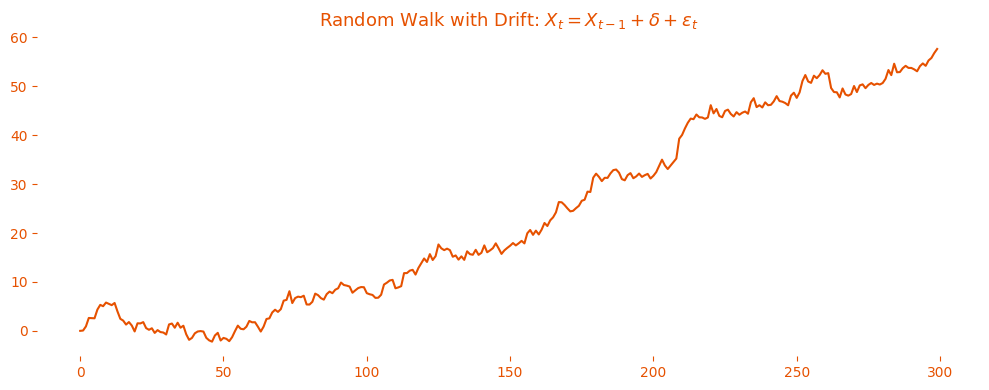

In [111]:
# --- Parameters ---
n = 300
delta = 0.2  # Drift term
np.random.seed(42)
noise = np.random.normal(0, 1, size=n)

# --- Generate Random Walk with Drift ---
random_walk = np.zeros(n)
for t in range(1, n):
    random_walk[t] = random_walk[t - 1] + delta + noise[t]

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(np.arange(n), random_walk, color="#e65100", linewidth=1.5)

# Styling
ax.set_title("Random Walk with Drift: $X_t = X_{t - 1} + \\delta + \\varepsilon_t$", fontsize=13, color="#e65100")
ax.tick_params(colors="#e65100")
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.savefig("./assets/random_walk_with_drift.png", dpi=300, transparent=True)
plt.show()


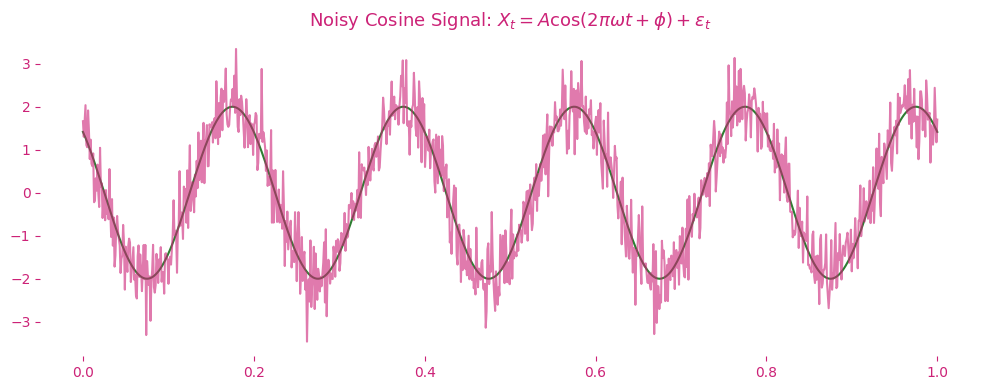

In [116]:
# --- Parameters ---
A = 2                   # Amplitude
omega = 5               # Frequency (Hz)
phi = np.pi / 4         # Phase shift (radians)
t = np.linspace(0, 1, 1000)
np.random.seed(42)

# --- Signals ---
signal_clean = A * np.cos(2 * np.pi * omega * t + phi)
noise_05 = np.random.normal(0, 0.5, len(t))
signal_noisy = signal_clean + noise_05

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 4))

# Plot both
ax.plot(t, signal_clean, label=r"Clean Signal", color="#2e7d32", linewidth=1.5)
ax.plot(t, signal_noisy, label=r"Noisy Signal ($\sigma = 0.5$)", color="#cc2277", linewidth=1.5, alpha=0.6)

# Styling
ax.set_title(r"Noisy Cosine Signal: $X_t = A \cos(2\pi \omega t + \phi) + \varepsilon_t$", fontsize=13, color="#cc2277")
ax.tick_params(colors="#cc2277")
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.savefig("./assets/noisy_cosine_signal.png", dpi=300, transparent=True)
plt.show()